# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for SBE-37 but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2023/Moorings/23kum2a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/sbe37/23KUM2Aa_sbe37_SN1869__1m.asc'
instrument = 'SBE-37 1869'
mooring_meta_file = user_data_dir+'logs/23KUM-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe37_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's37'
###############################################################

#init and load data
sbe37_wop = sbe_parser.sbe37()
(sbe37_wop_data,sbe37_wop_header) = sbe37_wop.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True) 

The data is output as a pandas dataframe from the intial module call and if its available, a header

In [4]:
sbe37_wop_header

['* Sea-Bird SBE37 Data File:\n',
 '* FileName = C:\\Users\\foci\\Documents\\2023\\instrument_download_practice\\23KUM2Aa_sbe37_SN1869__1m.asc\n',
 '* Software Version 1.59\n',
 '* Temperature SN = 1869\n',
 '* Conductivity SN = 1869\n',
 '* System UpLoad Time = Aug 26 2023 19:46:02\n',
 '** sbe-37s\n',
 '** 1869\n',
 '** realtime=08/26/2023 19:40:00\n',
 '** insttime=08/26/2023 19:41:36\n',
 '* ds\n',
 '* SBE37-SM V 2.6b  SERIAL NO. 1869    26 Aug 2023  19:45:45\n',
 '* not logging: received stop command\n',
 '* sample interval = 3600 seconds\n',
 '* samplenumber = 2996, free = 230020\n',
 '* do not transmit real-time data\n',
 '* output salinity with each sample\n',
 '* do not output sound velocity with each sample\n',
 '* store time with each sample\n',
 '* number of samples to average = 4\n',
 '* reference pressure = 1.0 db\n',
 '* serial sync mode disabled\n',
 '* wait time after serial sync sampling = 30 seconds\n',
 '* internal pump not installed\n',
 '* temperature = 14.12 deg 

In [5]:
sbe37_wop_data

,temperature,conductivity,salinity
date_time,,,
2023-04-24 00:01:25,2.8965,0.34254,3.1790
2023-04-24 01:01:25,3.7319,0.10667,0.9050
2023-04-24 02:01:24,2.1722,0.10594,0.9429
2023-04-24 03:01:24,1.8482,0.03315,0.2832
2023-04-24 04:01:25,1.7472,0.02956,0.2522
...,...,...,...
2023-08-26 15:01:25,11.4165,0.04952,0.3275
2023-08-26 16:01:25,11.5132,0.04705,0.3099
2023-08-26 17:01:25,11.5087,0.04436,0.2916


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean()
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
    + I suggest if no change is needed... resample().mean() to the sample frequency just in case there is a small deviation from expected (<1min)
    

In [6]:
sbe37_wop_data.index = sbe37_wop_data.index.round(freq='1H')
sbe37_wop_data

,temperature,conductivity,salinity
date_time,,,
2023-04-24 00:00:00,2.8965,0.34254,3.1790
2023-04-24 01:00:00,3.7319,0.10667,0.9050
2023-04-24 02:00:00,2.1722,0.10594,0.9429
2023-04-24 03:00:00,1.8482,0.03315,0.2832
2023-04-24 04:00:00,1.7472,0.02956,0.2522
...,...,...,...
2023-08-26 15:00:00,11.4165,0.04952,0.3275
2023-08-26 16:00:00,11.5132,0.04705,0.3099
2023-08-26 17:00:00,11.5087,0.04436,0.2916


<Axes: xlabel='date_time'>

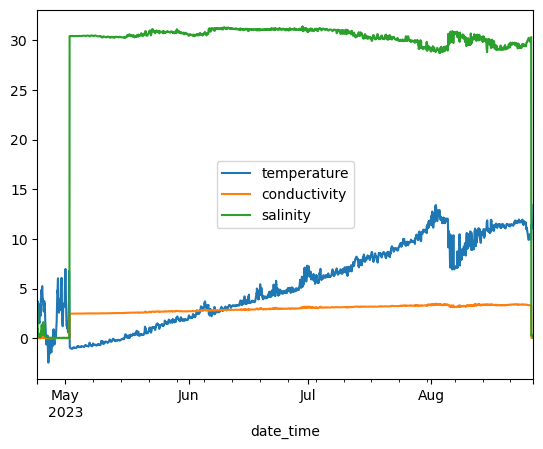

In [7]:
sbe37_wop_data.plot()

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [8]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [9]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [10]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [11]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
sbe37_wop_nc = ncCFsave.EcoFOCI_CFnc(df=sbe37_wop_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
sbe37_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [12]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
sbe37_wop_nc.expand_dimensions()

In [13]:
sbe37_wop_nc.variable_meta_data(variable_keys=list(sbe37_wop_data.columns.values),drop_missing=True)
sbe37_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
sbe37_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [14]:
#add global attributes
sbe37_wop_nc.deployment_meta_add()
sbe37_wop_nc.get_xdf()

#add instituitonal global attributes
sbe37_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
sbe37_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
sbe37_wop_nc.provinance_meta_add()

#provide intial qc status field
sbe37_wop_nc.qc_status(qc_status='unknown')

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [15]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})


In [16]:
sbe37_wop_nc.autotrim_time()

<xarray.Dataset> Size: 89kB
Dimensions:       (time: 2787, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 22kB 2023-05-02T03:00:00 ... 2023-08-...
  * latitude      (latitude) float64 8B 58.26
  * longitude     (longitude) float64 8B -163.5
  * depth         (depth) float64 8B 2.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 22kB -0.8619 ......
    conductivity  (time, depth, latitude, longitude) float64 22kB 2.49 ... 3.336
    salinity      (time, depth, latitude, longitude) float64 22kB 30.4 ... 30.3
Attributes: (12/33)
    Latitude_DegMMddW:                      58 15.67 N
    Longitude_DegMMddN:                     163 29.66 W
    MooringID:                              23KUM-2A
    platform_deployment_date:               2023-05-02T02:23:00Z
    platform_deployment_cruise_name:        DY2306
    platform_recovery_date:                 2023-08-26T05:17:00Z
    ...                                     ...
    InstrumentSerialNumber:                 1869
    InstrumentType:                         SBE-37
    date_created:                           2025-03-13T06:22:59Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [17]:
try:
    print(sbe37_wop_nc.autotrim_time().pressure.mean())
except:
    print(f'likely no pressure variable in datafile')

likely no pressure variable in datafile


<Figure size 640x480 with 0 Axes>

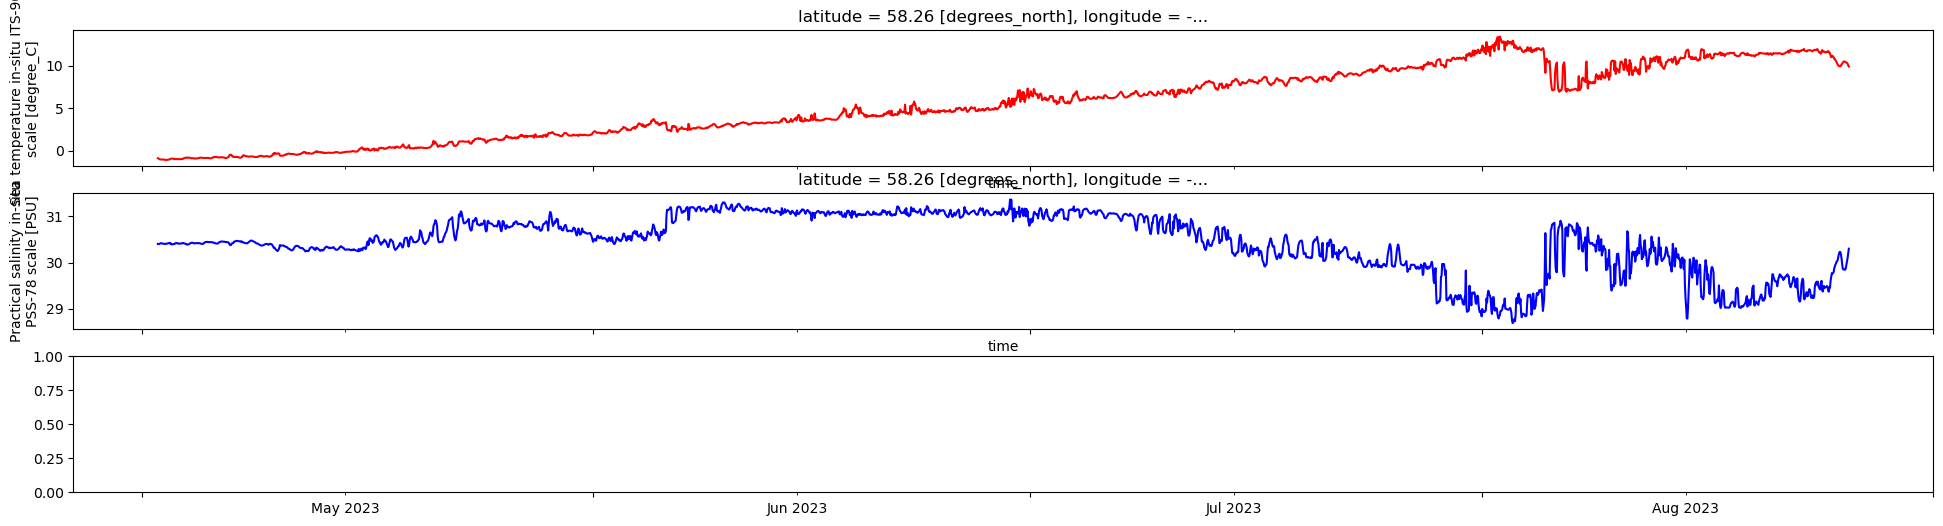

In [18]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


fig, ax = plt.subplots(3,figsize=(24, 6),sharex=True)
sbe37_wop_nc.autotrim_time().temperature.plot(ax=ax[0],color='r')
sbe37_wop_nc.autotrim_time().salinity.plot(ax=ax[1],color='b')
try:
    sbe37_wop_nc.autotrim_time().pressure.plot(ax=ax[2],color='k')
except:
    pass

# xfmt = mdates.DateFormatter('%d-%b')
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))
ax[2].xaxis.set_tick_params(which='major', pad=3)
ax[2].xaxis.set_tick_params(which='minor', pad=5)

In [19]:
#csvoutput if necessary - untrimmed for deck analysis
(sbe37_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

**no pressure var - so assume pressure correction from other depths**

## QC plotting against CTDs (here or in a seperate ipynb)

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import EcoFOCIpy.io.erddap as erddap
import datetime

url = "http://ecofoci-field.pmel.noaa.gov:8082/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [26]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2306',qclevel='preliminary',concastno='073')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='aq2301',qclevel='preliminary',concastno='006')

some variable names switch between preliminary and final... this will eventually be resolved

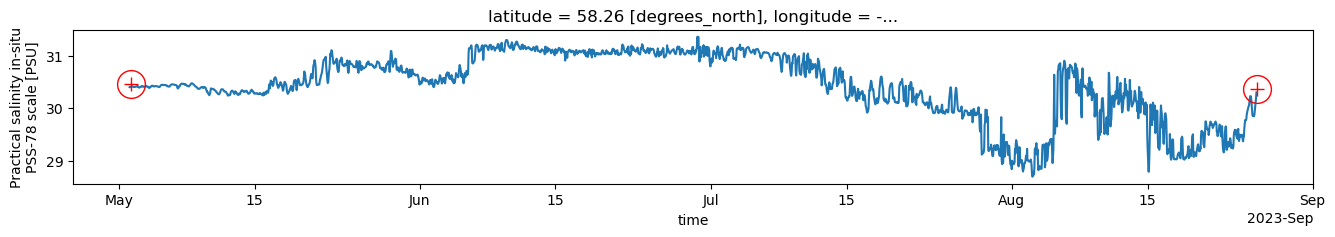

In [27]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])
depth = 5
fig, ax = plt.subplots(1,figsize=(16, 2))
sbe37_wop_nc.autotrim_time().salinity.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

fig.savefig(f"images/{filename.replace('nc','_salCal.png')}")

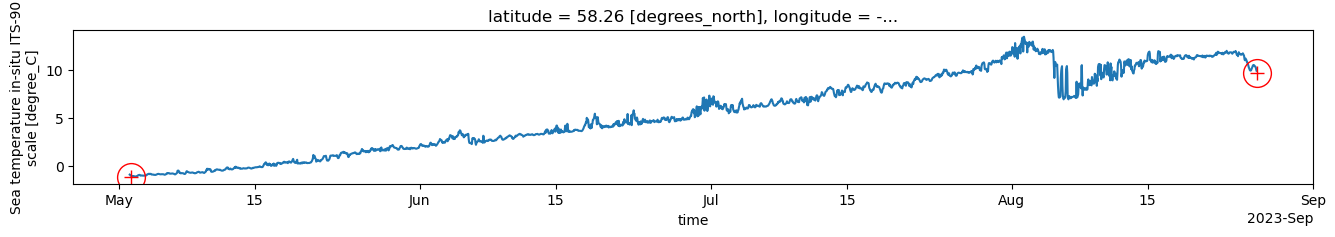

In [28]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
# depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe37_wop_nc.autotrim_time().temperature.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['T_28 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['T_28 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['T_28 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['T_28 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

fig.savefig(f"images/{filename.replace('nc','_tempCal.png')}")

In [30]:
#print collocated cast comparison
mooring = sbe37_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(depcast['time (UTC)'].unique()[0],
                                                                 '%Y-%m-%dT%H:%M:%SZ'),
                                 method='nearest')
print('Deployment')
print('T0:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['T_28 (degree_C)'].values)
print('T1:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['T2_35 (degree_C)'].values)
print('S0:',mooring.salinity.values[0][0],depcast[depcast['pressure'] == depth]['S_41 (PSU)'].values)
print('S1:',mooring.salinity.values[0][0],depcast[depcast['pressure'] == depth]['S_42 (PSU)'].values)

mooring = sbe37_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(reccast['time (UTC)'].unique()[0],
                                                                 '%Y-%m-%dT%H:%M:%SZ'),
                                 method='nearest')
print('Recovery')
print('T0:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['T_28 (degree_C)'].values)
print('T1:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['T2_35 (degree_C)'].values)
print('S0:',mooring.salinity.values[0][0],reccast[reccast['pressure'] == depth]['S_41 (PSU)'].values)
print('S1:',mooring.salinity.values[0][0],reccast[reccast['pressure'] == depth]['S_42 (PSU)'].values)


Deployment
T0: [-0.9985] [-1.0814]
T1: [-0.9985] [-1.0784]
S0: [30.4134] [30.4673]
S1: [30.4134] [30.4679]
Recovery
T0: [9.8854] [9.6759]
T1: [9.8854] [9.683]
S0: [30.2992] [30.3613]
S1: [30.2992] [30.361]
